In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import itertools
import os
from itertools import combinations
import math

In [2]:
# Function that checks for isosceles triangles and removes the smallest number of points required to make the matrix non-isosceles
# Use this when using courser reward functions and aggressive learning rates. 

def is_isosceles_remove(matrix):
    ones = np.argwhere(matrix == 1)
    for comb in itertools.combinations(ones, 3):
        comb = np.array(comb)
        distances = np.sqrt(np.sum((comb - comb[:, np.newaxis])**2, axis=-1))
        if np.allclose(distances[0], distances[1]) or np.allclose(distances[1], distances[2]) or np.allclose(distances[0], distances[2]):
            # Remove the smallest number of points required to make the triangle non-isosceles
            for i in range(3):
                if np.allclose(distances[i], distances[(i+1)%3]):
                    # remove point i
                    matrix[tuple(comb[i])] = 0
                    return True, matrix
    return False, matrix


In [3]:
# Function that checks for isosceles triangles

def is_isosceles(matrix):
    ones = np.argwhere(matrix == 1)
    count = 0
    for comb in itertools.combinations(ones, 3):
        comb = np.array(comb)
        distances = np.sqrt(np.sum((comb - comb[:, np.newaxis])**2, axis=-1))
        if np.allclose(distances[0], distances[1]) or np.allclose(distances[1], distances[2]) or np.allclose(distances[0], distances[2]):
            count += 1
    if count > 0:
        return True
    else:
        return False

In [4]:
def torus_distance(i1, j1, i2, j2, rows, cols):
    # Calculate the minimum distance horizontally
    d1 = abs(j2 - j1)
    d1 = min(d1, cols - d1)

    # Calculate the minimum distance vertically
    d2 = abs(i2 - i1)
    d2 = min(d2, rows - d2)

    # Calculate the torus distance using Pythagorean theorem
    return np.sqrt(d1**2 + d2**2)

In [5]:
# Write a function that takes a binary matrix and computes the nubmer of isosceles triangles
def count_isosceles_triangles(matrix):
    count = 0
    # Get the location of all the ones in the matrix
    ones = np.argwhere(matrix == 1)
    # Iterate over all possible combinations of three points
    for comb in itertools.combinations(ones, 3):
        comb = np.array(comb)
        # Compute the distances between the three points using the torus distance
        distances = np.array([torus_distance(comb[0][0], comb[0][1], comb[1][0], comb[1][1], matrix.shape[0], matrix.shape[1]),
                                torus_distance(comb[1][0], comb[1][1], comb[2][0], comb[2][1], matrix.shape[0], matrix.shape[1]),
                                torus_distance(comb[0][0], comb[0][1], comb[2][0], comb[2][1], matrix.shape[0], matrix.shape[1])])
        # Check if any two distances are equal
        if np.allclose(distances[0], distances[1]) or np.allclose(distances[1], distances[2]) or np.allclose(distances[0], distances[2]):
            count += 1
    return count
                              

In [6]:
# Helper function to plot boards nicely

def plot_board(matrix):

    n = len(matrix)
    data = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if matrix[i][j] == 1:
                data[i][j] = 1
    sns.set_style("whitegrid", {'axes.grid': False})
    sns.heatmap(data, cmap='Oranges', square=True, cbar=False, linewidth=1,
                linecolor='gray', annot=False, fmt='g')



In [7]:
# Helper function to read data from the bitwise model

def read_timeline(n):
    #Uncomment this line if you want to read the unpreprocessed data from the bitwise model
    # filename = f'{n}x{n}_best_species_timeline.txt' 
    filename = f'torus_grid_{str(n)}.txt'
    filepath = os.path.join('Data', filename)
    with open(filepath, 'r') as f:
        timeline = f.read()
    return timeline

# Helper function that counts the number of ones. Mainly here for readability

def count_ones(matrix):
    return np.sum(matrix)

# Sieving through the generated matrices and remove duplicates that are rotations of each other

def get_unique_rotations(matrix):
    rotations = []
    for i in range(4):
        rotated = np.rot90(matrix, i)
        if not any(np.array_equal(rotated, r) for r in rotations):
            rotations.append(rotated)
    return rotations

# Helper function that parses through the timeline and returns a list of numpy matrices

def parse_timeline(n):
    timeline = read_timeline(n)

    # Parse the matrices into an easier format for numpy
    timeline = timeline.replace('[', '').replace(']', '').replace(',', '').replace('1.', '1').replace('0.', '0').replace(' ', '').replace('\n', '')

    # Split the timeline into distinct nxn numpy matrices
    matrices = []
    for i in range(len(timeline) // (n**2)):
        matrix = np.zeros((n, n))
        for j in range(n):
            for k in range(n):
                matrix[j][k] = int(timeline[i*n**2 + j*n + k])
        matrices.append(matrix)

    return matrices

def visualize_boards(n):
    matrices = parse_timeline(n)
    max_ones = max(np.count_nonzero(matrix == 1) for matrix in matrices)

    # Visualize the matrix with the most ones
    for matrix in matrices:
        if np.count_nonzero(matrix == 1) == max_ones:
            flag = is_isosceles(matrix)
            if not flag:
                plot_board(matrix)
                break
            else:
                plot_board(np.zeros((n,n)))
        


Number of ones:  13.0


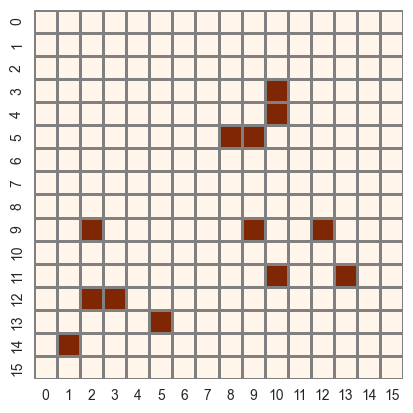

In [8]:
# Example usage
n = 16 #Change this to print different boards
matrix = parse_timeline(n)
visualize_boards(n)
print("Number of ones: ", count_ones(matrix))

Number of ones:  8.0


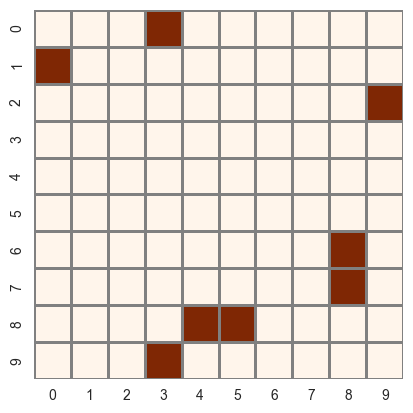

In [9]:
# Example usage
n = 10 #Change this to print different boards
matrix = parse_timeline(n)
visualize_boards(n)
print("Number of ones: ", count_ones(matrix))

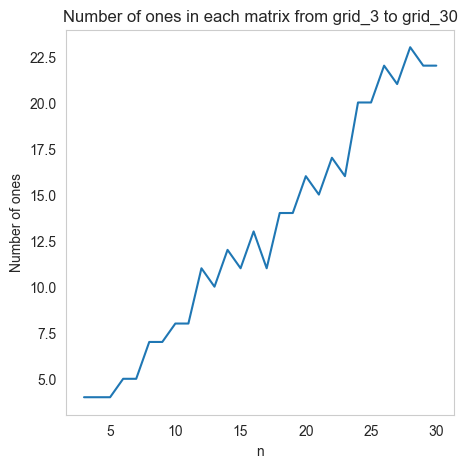

In [10]:
# Plot the number of ones in each matrix from grid_3 to grid_30

ones = []
for i in range(3, 31):
    matrices = parse_timeline(i)
    ones.append([count_ones(matrix) for matrix in matrices])

ones = np.array(ones).reshape(-1,1) 

plt.figure(figsize=(5, 5))
plt.plot(range(3, 31), ones)
plt.xlabel('n')
plt.ylabel('Number of ones')
plt.title('Number of ones in each matrix from grid_3 to grid_30')
plt.show()


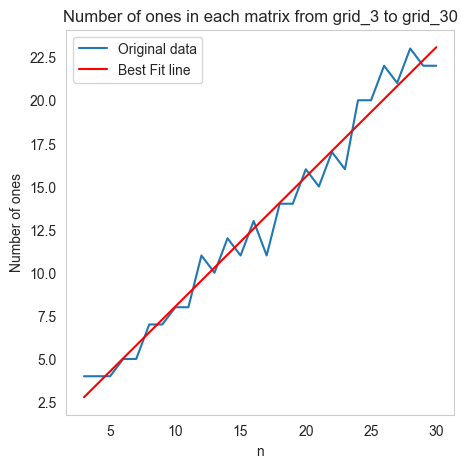

Slope of the line of best fit:  [0.7515052]


In [11]:
# Plot the line of best fit for the number of ones in each matrix from grid_3 to grid_30

ones = []
for i in range(3, 31):
    matrices = parse_timeline(i)
    ones.append([count_ones(matrix) for matrix in matrices])

ones = np.array(ones).reshape(-1,1)

x = np.arange(3, 31).reshape(-1,1)
y = ones

# Fit a line to the data using the least squares method
A = np.hstack([x, np.ones(x.shape)])
m, c = np.linalg.lstsq(A, y, rcond=None)[0]

plt.figure(figsize=(5, 5))
plt.plot(x, y, '-', label='Original data', markersize=5)
plt.plot(x, m*x + c, 'r', label='Best Fit line')
plt.xlabel('n')
plt.ylabel('Number of ones')
plt.title('Number of ones in each matrix from grid_3 to grid_30')
plt.legend()
plt.show()

# Print the slope of the line of best fit
print("Slope of the line of best fit: ", m)